In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from astropy import units as u

## Class to organize auto- and cross-spectra of components at different frequencies

In [26]:
class spectra():
    
    def __init__(self, base_dir, ellmax, freqs, comps, gg_shot_noise, noise=None):
        self.base_dir = base_dir
        self.ellmax = ellmax
        self.freqs = freqs
        self.comps = comps
        self.gg_shot_noise = gg_shot_noise
        self.noise = noise #dimensions (nfreqs x ellmax)
        #index as all_spectra[a][i][b][j] for cross-spectrum of component a at frequency i with component b at frequency j
        self.all_spectra = np.zeros((len(comps), len(freqs), len(comps), len(freqs), ellmax+1)) 
        #index as comp_cross_g_spectra[a][i][b] for cross-spectrum component a at frequency i with g blue green red
        self.comp_cross_g_spectra = np.zeros((len(comps), len(freqs), 3, ellmax+1))
        #g_a x g_b spectra, index 0 for blue, 1 for green, 2 for red
        self.gg_spectrum = np.zeros((3,3,ellmax+1))
        #list of ells
        self.ells = np.arange(ellmax+1)
    
    @staticmethod
    def get_file_name(base_dir, freq1, freq2, comp1, comp2):
        fname = f'{base_dir}/ell_dl_'
        if comp1==comp2=='CMB':
            return f'{base_dir}/ell_dl_CMB.txt'
        if comp1 in {'g_blue', 'g_green', 'g_red'} and comp2 in {'g_blue', 'g_green', 'g_red'}:
            return f'{base_dir}/ell_dl_gg_{comp1[2:]}_{comp2[2:]}.txt'
        else:
            fname += f'{freq1}x{freq2}_GHz_{comp1}x{comp2}.txt' 
        return fname
    
    def log_interp(self, ells, spectrum):
        if np.all(spectrum >= 0):
            log_spectrum = np.log(spectrum)
            f = interp1d(ells, log_spectrum, fill_value="extrapolate")
            return np.exp(f(self.ells))
        else:
            log_neg_spectrum = np.log(-spectrum)
            f = interp1d(ells, log_neg_spectrum, fill_value="extrapolate")
            return -np.exp(f(self.ells))
    
    
    def get_ksz_auto_spectra(self, plot=False):
        ksz_patchy_file = open(f'{self.base_dir}/FBN_kSZ_PS_patchy.d.txt', 'r')
        rows = ksz_patchy_file.readlines()
        for i, line in enumerate(rows):
            rows[i] = line.lstrip(' ').replace('\n', '').split()
        rows = np.asarray(rows, dtype=np.float32)
        cols = np.transpose(rows)
        ells_ksz_patchy, ksz_patchy = cols
        ksz_patchy = self.log_interp(ells_ksz_patchy, ksz_patchy)

        ksz_nonpatchy_file = open(f'{self.base_dir}/FBN_kSZ_PS.d.txt', 'r')
        rows = ksz_nonpatchy_file.readlines()
        for i, line in enumerate(rows):
            rows[i] = line.lstrip(' ').replace('\n', '').split()
        rows = np.asarray(rows, dtype=np.float32)
        cols = np.transpose(rows)
        ells_ksz_nonpatchy, ksz_nonpatchy = cols
        ksz_nonpatchy = self.log_interp(ells_ksz_nonpatchy, ksz_nonpatchy)

        ksz = ksz_patchy + ksz_nonpatchy

        if plot:
            plt.clf()
            plt.plot(self.ells, ksz_patchy, label='patchy')
            plt.plot(self.ells, ksz_nonpatchy, label='non-patchy')
            plt.plot(self.ells, ksz, label='total kSZ')
            plt.title('kSZ Auto-Spectra')
            plt.legend()
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}$ [$\mu K^2$]')
        ksz = ksz/((self.ells)*(self.ells+1))*(2*np.pi)
        ksz[0] = 0
        return ksz
    
    def get_noise_auto_spectra(self, freq, plot=False):
        noise_file = open(f'{base_dir}/so_noise/noise_{freq}GHz.txt', 'r')
        rows = noise_file.readlines()
        for i, line in enumerate(rows):
            rows[i] = line.lstrip(' ').replace('\n', '').split()
        rows = np.asarray(rows, dtype=np.float32)
        ells_noise, noise = rows
        noise = self.log_interp(ells_noise, noise)
        if plot:
            plt.plot(self.ells, self.ells*(self.ells+1)*noise/(2*np.pi)) #noise needs to be put into Dl for plotting
            plt.title(f'Noise Auto-Spectrum {freq} GHz')
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}$ [$\mu K^2$]')
        return noise
    
    @staticmethod
    def tsz_spectral_response(freqs): #input frequency in GHz
        T_cmb = 2.726
        h = 6.62607004*10**(-34)
        kb = 1.38064852*10**(-23)
        f = 1. #fsky
        response = []
        for freq in freqs:
            x = h*(freq*10**9)/(kb*T_cmb) #x is v/56.9 GHz
            response.append(T_cmb*(x*1/np.tanh(x/2)-4)) #was factor of tcmb microkelvin before
        return np.array(response)

    
    def populate_all_spectra(self, plot=False):
        '''
        populate all_spectra with files, index as all_spectra[a][i][b][j]
        '''
        for a, comp1 in enumerate(self.comps):
            for i, freq1 in enumerate(self.freqs):
                plt.clf()
                for b, comp2 in enumerate(self.comps):
                    for j, freq2 in enumerate(self.freqs):
                        if comp1==comp2=='kSZ':
                            spectrum = self.get_ksz_auto_spectra()
                        elif comp1=='kSZ' or comp2=='kSZ': #kSZ cross anything is 0
                            continue
                        elif comp1==comp2=='noise':
                            if i==j:
                                if self.noise is None:
                                    spectrum = self.get_noise_auto_spectra(self.freqs[i])
                                else:
                                    spectrum = self.noise[i]
                            else:
                                spectrum = np.zeros(self.ellmax+1)
                        elif comp1=='noise' or comp2=='noise': #noise cross anything is 0
                            continue
                        elif (comp1=='CMB' or comp2=='CMB') and not (comp1=='CMB' and comp2=='CMB'): #CMB cross anything is 0
                            continue
                        else:
                            try:
                                file = open(self.get_file_name(self.base_dir, freq1, freq2, comp1, comp2), 'r')
                            except FileNotFoundError:
                                file = open(self.get_file_name(self.base_dir, freq1, freq2, comp2, comp1), 'r')
                            ells_here, spectrum = file.readlines()
                            ells_here = np.asarray(ells_here.split(' '), dtype=np.float32)
                            spectrum = np.asarray(spectrum.split(' '), dtype=np.float32)
                            spectrum = self.log_interp(ells_here, spectrum)
                            spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
                            spectrum[0] = 0
                        self.all_spectra[a][i][b][j] = spectrum
                        if plot:
                            plt.plot(self.ells, self.ells*(self.ells+1)*spectrum/(2*np.pi), label=f'{comp1}_{freq1}GHz, {comp2}_{freq2}GHz')
                if plot:
                    plt.xlabel(r'$\ell$')
                    plt.ylabel(r'$D_{\ell}$')
                    plt.legend()
                    plt.show()
        return self.all_spectra
    
    def populate_comp_cross_g_spectra(self, plot=False):
        '''
        populate comp_cross_g_spectra
        index as comp_cross_g_spectra[a][i][b], where b indexes unWISE blue, green, red
        '''
        plt.clf()
        for a, comp in enumerate(self.comps):
            if comp=='kSZ' or comp=='noise' or comp=='CMB':
                continue
            for i, freq in enumerate(self.freqs):
                for b, color in enumerate(['g_blue', 'g_green', 'g_red']):
                    file = open(self.get_file_name(self.base_dir, freq, freq, comp, color), 'r')
                    ells_here, spectrum = file.readlines()
                    ells_here = np.asarray(ells_here.split(' '), dtype=np.float32)
                    spectrum = np.asarray(spectrum.split(' '), dtype=np.float32)
                    f_spectrum = interp1d(ells_here, spectrum, fill_value="extrapolate")
                    spectrum = f_spectrum(self.ells)
                    spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)
                    spectrum[0] = 0
                    self.comp_cross_g_spectra[a][i][b] = spectrum
                    if plot:
                        plt.plot(self.ells, self.ells*(self.ells+1)*spectrum/(2*np.pi), label=f'{comp} {freq} GHz x {color}')
        if plot:
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}$')
            plt.legend()
            plt.show()
        return self.comp_cross_g_spectra 
    
    def populate_gg_spectrum(self, plot=False):
        '''
        populate gg auto- and cross-spectra
        index as gg_spectrum[a][b][l] where a and b index unWISE blue, green, red
        '''
        plt.clf()
        for a, color1 in enumerate(['blue', 'green', 'red']):
            for b, color2 in enumerate(['blue', 'green', 'red']):
                file = open(f'{base_dir}/ell_dl_gg_{color1}_x_{color2}.txt', 'r')
                ells_gg, gg = file.readlines()
                ells_gg = np.asarray(ells_gg.split(' '), dtype=np.float32)
                gg = np.asarray(gg.split(' '), dtype=np.float32)
                f_gg = interp1d(ells_gg, gg, fill_value="extrapolate")
                gg = f_gg(self.ells)
                if plot:
                    plt.plot(self.ells, gg, label='gg signal')
                    gg_shot_noise = self.gg_shot_noise[a][b]
                    plt.plot(self.ells, self.ells*(self.ells+1)*gg_shot_noise/(2*np.pi), label='gg shot noise')
                    plt.plot(self.ells, gg+self.ells*(self.ells+1)*gg_shot_noise/(2*np.pi), label='total gg spectrum')
                    plt.title(f'gg {color1} x {color2} Spectrum')
                    plt.xlabel(r'$\ell$')
                    plt.ylabel(r'$D_{\ell}$ [$\mu K^2$]')
                    plt.yscale('log')
                    plt.legend()
                    plt.show()
                self.gg_spectrum[a][b] = gg/(self.ells*(self.ells+1))*(2*np.pi)
                self.gg_spectrum[a][b][0] = 0
                self.gg_spectrum[a][b] += gg_shot_noise
        return self.gg_spectrum
    
    def get_cls(self, plot=False):
        self.populate_all_spectra(plot=plot)
        self.populate_comp_cross_g_spectra(plot=plot)
        self.populate_gg_spectrum(plot=plot)
        self.Clij = np.einsum('aibjl->ijl', self.all_spectra) #index as Clij[i][j][l]
        self.Clig = np.einsum('aibl->ibl', self.comp_cross_g_spectra) #index as Clig[i][b][l]
        self.Clgg = self.gg_spectrum #index as Clgg[a][b][l]
        if plot:
            plt.clf()
            for i in range(len(freqs)):
                for j in range(len(freqs)):
                    plt.plot(self.ells, self.ells*(self.ells+1)*self.Clij[i][j]/(2*np.pi), label=r'$D_{\ell}$ '+f'{freqs[i]}, {freqs[j]}')
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}$')
            plt.title(r'$D_{\ell}^{ij}$')
            plt.yscale('log')
            plt.legend()
            plt.show()

            plt.clf()
            for i in range(len(freqs)):
                for b in range(3):
                    plt.plot(self.ells, self.ells*(self.ells+1)*self.Clig[i][b]/(2*np.pi), label=f'{freqs[i]} GHz, color {b}')
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}$')
            plt.title(r'$D_{\ell}^{ig}$')
            plt.legend()
            plt.show()

            plt.clf()
            for a in range(3):
                for b in range(3):
                    plt.plot(self.ells, self.ells*(self.ells+1)*self.Clgg[a][b]/(2*np.pi), label=f'colors {a} and {b}')
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}$')
            plt.legend()
            plt.title(r'$D_{\ell}^{gg}$')
            plt.yscale('log')
            plt.show()
        return self.Clij, self.Clig, self.Clgg

## Class for performing ILC (preserved kSZ, deprojected tSZ) but with no CIB component and no constraints on g

In [27]:
class ILC_no_CIB_no_g():
    
    def __init__(self, spectra, deltal):
        self.ellmax = spectra.ellmax
        self.ells = spectra.ells
        self.freqs = spectra.freqs
        self.comps = spectra.comps
        cib_idx = self.comps.index('CIB')
        self.all_spectra = np.delete(np.copy(spectra.all_spectra), (cib_idx), axis=0)
        self.all_spectra = np.delete(self.all_spectra, (cib_idx), axis=2)
        self.Clij = np.einsum('aibjl->ijl', self.all_spectra) #index as Clij[i][j][l]
        self.spectra = spectra
        self.deltal = deltal
    
    def Rlij(self):
        #Construct Rlij
        prefactor = (2*self.ells+1)/(4*np.pi)
        Rlij_no_binning = np.einsum('l,ijl->ijl', prefactor, self.Clij)
        self.Rlij = np.zeros((len(self.freqs), len(self.freqs), self.ellmax+1)) 
        for i in range(len(self.freqs)):
            for j in range(len(self.freqs)):
                self.Rlij[i][j] = (np.convolve(Rlij_no_binning[i][j], np.ones(2*self.deltal+1)))[self.deltal:self.ellmax+1+self.deltal]
        return self.Rlij
    
    def Rlij_inv(self): 
        #Get inverse of R_{\ell}^{ij '}
        self.Rlij_inv = np.array([np.linalg.inv(self.Rlij[:,:,l]) for l in range(self.ellmax+1)]) 
        return self.Rlij_inv #index as Rlij_inv[l][i][j]
        
    def get_ab(self):
        self.a = np.ones(len(self.freqs)) #index as a[i]
        self.b = spectra.tsz_spectral_response(self.freqs) #index as b[i]
        return self.a, self.b
    
    def get_ABD(self):
        self.A = np.einsum('lij,i,j->l', self.Rlij_inv, self.a, self.a)
        self.B = np.einsum('lij,i,j->l', self.Rlij_inv, self.b, self.b)
        self.D = np.einsum('lij,i,j->l', self.Rlij_inv, self.a, self.b)
        return self.A, self.B, self.D
    
    def weights(self):
        #get weights
        numerator = np.einsum('lij,l,i->jl', self.Rlij_inv, self.B, self.a) \
                    - np.einsum('lij,l,i->jl', self.Rlij_inv, self.D, self.b)
        denominator = np.einsum('l,l->l', self.A, self.B) - np.einsum('l,l->l', self.D, self.D)
        self.w = numerator/denominator #index as w[i][l]
        return self.w
    
    def ILC_auto_spectrum(self, plot=False):
        self.Rlij()
        self.Rlij_inv()
        self.get_ab()
        self.get_ABD()
        self.weights()
        #Get power spectrum of ILC map
        self.Clyy = np.einsum('il,jl,ijl->l', self.w, self.w, self.Clij) 
        if plot:
            plt.clf()
            plt.plot(self.ells, self.ells*(self.ells+1)*self.Clyy/(2*np.pi))
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}^{\hat{y}\hat{y}}$ (ILC without CIB or g)')
            plt.yscale('log')
            plt.show()
        return self.Clyy
        

## Class for performing ILC (preserved kSZ, deprojected tSZ) with all components including CIB but no constraints on g

In [28]:
class ILC_no_g():
    
    def __init__(self, spectra, deltal):
        self.ellmax = spectra.ellmax
        self.ells = spectra.ells
        self.freqs = spectra.freqs
        self.comps = spectra.comps
        self.spectra = spectra
        self.Clij = spectra.Clij
        self.deltal = deltal
    
    def Rlij(self):
        #Construct Rlij
        prefactor = (2*self.ells+1)/(4*np.pi)
        Rlij_no_binning = np.einsum('l,ijl->ijl', prefactor, self.Clij)
        self.Rlij = np.zeros((len(self.freqs), len(self.freqs), self.ellmax+1)) 
        for i in range(len(self.freqs)):
            for j in range(len(self.freqs)):
                self.Rlij[i][j] = (np.convolve(Rlij_no_binning[i][j], np.ones(2*self.deltal+1)))[self.deltal:self.ellmax+1+self.deltal]
        return self.Rlij
    
    def Rlij_inv(self): 
        #Get inverse of R_{\ell}^{ij '}
        self.Rlij_inv = np.array([np.linalg.inv(self.Rlij[:,:,l]) for l in range(self.ellmax+1)]) 
        return self.Rlij_inv #index as Rlij_inv[l][i][j]
        
    def get_ab(self):
        self.a = np.ones(len(self.freqs)) #index as a[i]
        self.b = spectra.tsz_spectral_response(self.freqs) #index as b[i]
        return self.a, self.b
    
    def get_ABD(self):
        self.A = np.einsum('lij,i,j->l', self.Rlij_inv, self.a, self.a)
        self.B = np.einsum('lij,i,j->l', self.Rlij_inv, self.b, self.b)
        self.D = np.einsum('lij,i,j->l', self.Rlij_inv, self.a, self.b)
        return self.A, self.B, self.D
    
    def weights(self):
        #get weights
        numerator = np.einsum('lij,l,i->jl', self.Rlij_inv, self.B, self.a) \
                    - np.einsum('lij,l,i->jl', self.Rlij_inv, self.D, self.b)
        denominator = np.einsum('l,l->l', self.A, self.B) - np.einsum('l,l->l', self.D, self.D)
        self.w = numerator/denominator #index as w[i][l]
        return self.w
    
    def ILC_auto_spectrum(self, plot=False):
        self.Rlij()
        self.Rlij_inv()
        self.get_ab()
        self.get_ABD()
        self.weights()
        #Get power spectrum of ILC map
        self.Clyy = np.einsum('il,jl,ijl->l', self.w, self.w, self.Clij) 
        if plot:
            plt.clf()
            plt.plot(self.ells, self.ells*(self.ells+1)*self.Clyy/(2*np.pi))
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}^{\hat{y}\hat{y}}$ (ILC without CIB)')
            plt.yscale('log')
            plt.show()
        return self.Clyy
        

## Class for de-CIBing Method

In [29]:
class de_CIB():
    
    def __init__(self, spectra, deltal):
        self.ellmax = spectra.ellmax
        self.ells = spectra.ells
        self.freqs = spectra.freqs
        self.comps = spectra.comps
        self.spectra = spectra
        self.Clij = spectra.Clij
        self.Clig = spectra.Clig
        self.Clgg = spectra.Clgg
        self.deltal = deltal
    
    def get_ILC_no_g(self):
        ILC = ILC_no_g(self.spectra, self.deltal)
        self.ILC_auto_spectrum = ILC.ILC_auto_spectrum()
        self.w = ILC.w
        
    def get_rho_ab(self):
        self.rho_ab = np.zeros((3,3,self.ellmax+1)) #index as rho[a][b][l]
        for a in range(3):
            for b in range(3):
                self.rho_ab[a][b] = self.Clgg[a][b]/np.sqrt(self.Clgg[a][a]*self.Clgg[b][b])
    
    def get_rho_ab_inv(self):
        rho_ab_T = np.transpose(self.rho_ab, (2,0,1))
        self.rho_ab_inv = np.array([np.linalg.inv(rho_ab_T[l]) for l in range(self.ellmax+1)])
        self.rho_ab_inv = np.transpose(self.rho_ab_inv, (1,2,0))
    
    def get_rho_cib(self):
        self.rho_cib = np.zeros((3,len(self.freqs), self.ellmax+1)) #index as rho[b][i for CIB freq][l]
        cib_idx = self.comps.index('CIB')
        for b in range(3):
            for i in range(len(freqs)):
                self.rho_cib[b][i] = self.spectra.comp_cross_g_spectra[cib_idx][i][b]/np.sqrt(self.spectra.all_spectra[cib_idx,i,cib_idx,i] * self.Clgg[b,b])
    
    def get_c(self):
        self.c = np.zeros((len(self.freqs), 3, self.ellmax+1)) #index as c[i][a][l]
        cib_idx = self.comps.index('CIB')
        self.c = np.einsum('abl,bil,iil,aal->ial', self.rho_ab_inv, self.rho_cib, np.sqrt(self.spectra.all_spectra[cib_idx,:,cib_idx,:,:]), 1/np.sqrt(self.Clgg))
                
    
    def get_f(self):
        cib_idx = self.spectra.comps.index('CIB')
        num = np.einsum('ial,ial->il', self.c, self.spectra.comp_cross_g_spectra[cib_idx])
        denom = np.einsum('ial,ibl,abl->il', self.c, self.c, self.Clgg)
        self.f = num/denom #index as f[i][l]
    
    
    def auto_spectrum(self, plot=False):
        self.get_ILC_no_g()
        self.get_rho_ab()
        self.get_rho_ab_inv()
        self.get_rho_cib()
        self.get_c()
        self.get_f()
        self.Clyy = self.ILC_auto_spectrum
        self.Clyy += -2*np.einsum('il,jl,il,ial,jal->l', self.w, self.w, self.f, self.c, self.Clig)
        self.Clyy += np.einsum('il,jl,il,jl,ial,jbl,abl->l', self.w, self.w, self.f, self.f, self.c, self.c, self.Clgg)
        if plot:
            plt.clf()
            plt.plot(self.ells, self.ells*(self.ells+1)*self.Clyy/(2*np.pi))
            plt.xlabel(r'$\ell$')
            plt.ylabel(r'$D_{\ell}^{\hat{y}\hat{y}}$ (de-CIB)')
            plt.yscale('log')
            plt.show()
        return self.Clyy
        

## Example with 4 frequencies, 4 components and noise

/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_84914/2520564436.py:32: RuntimeWarning: divide by zero encountered in log
  log_spectrum = np.log(spectrum)


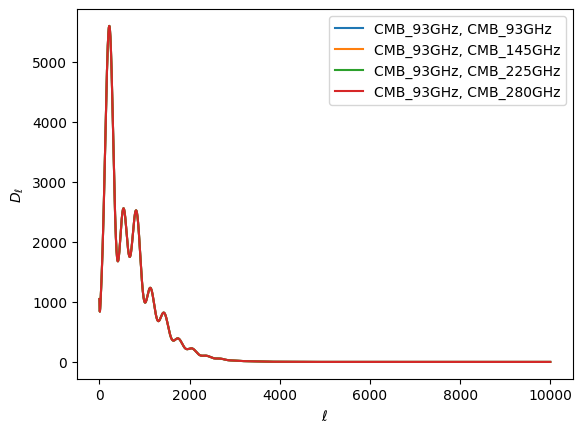

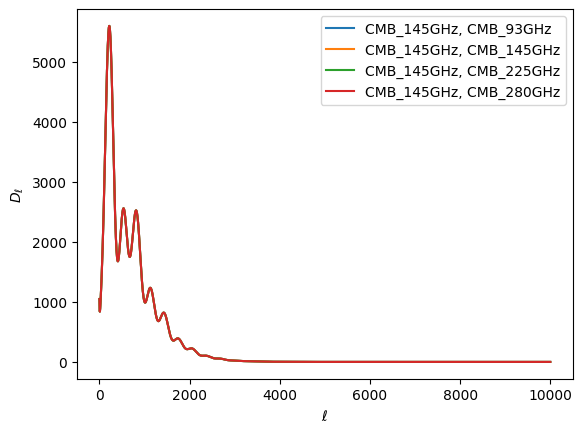

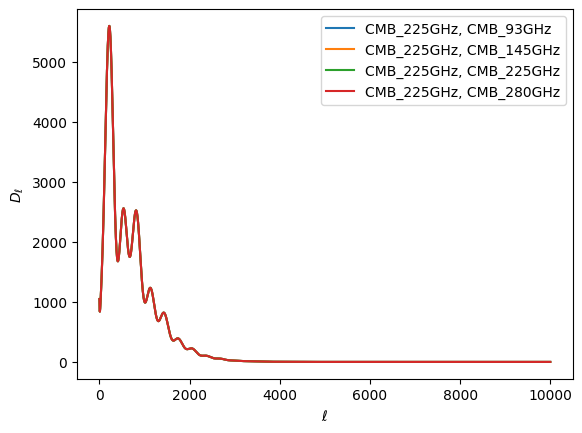

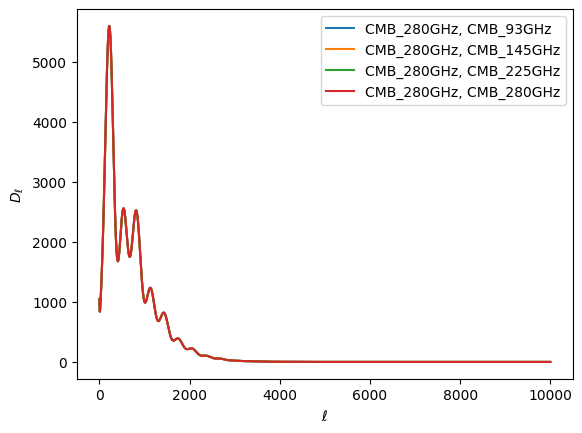

/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_84914/2520564436.py:137: RuntimeWarning: divide by zero encountered in true_divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)


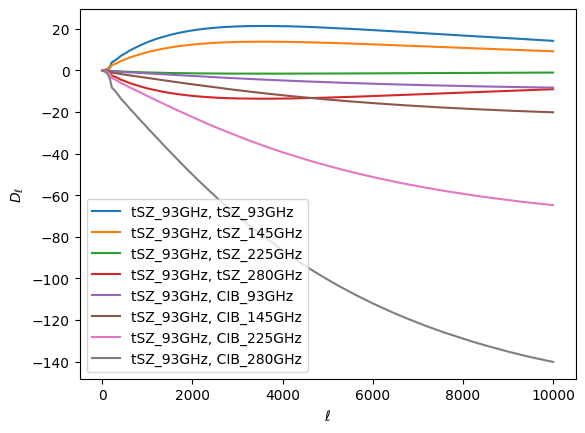

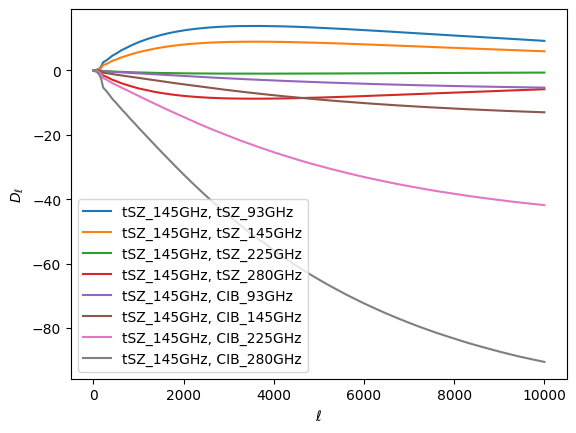

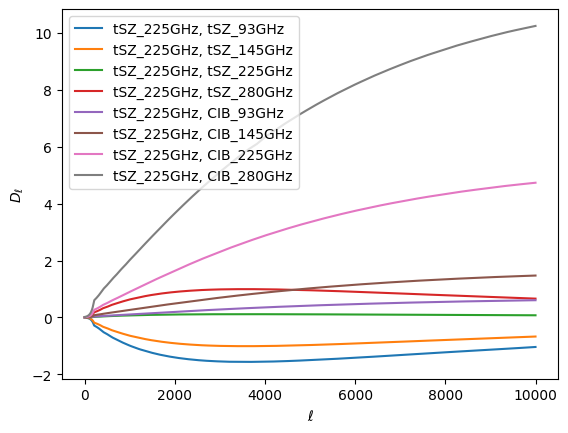

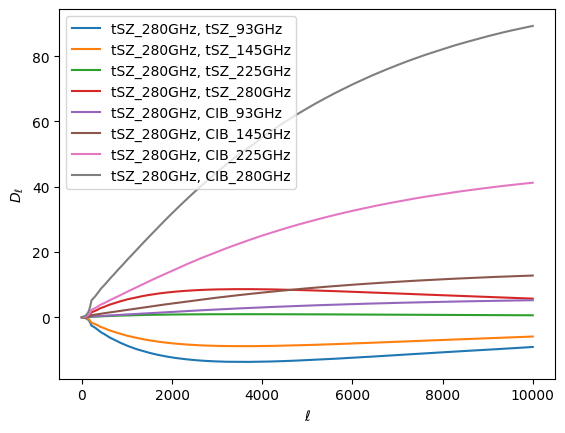

/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_84914/2520564436.py:71: RuntimeWarning: divide by zero encountered in true_divide
  ksz = ksz/((self.ells)*(self.ells+1))*(2*np.pi)


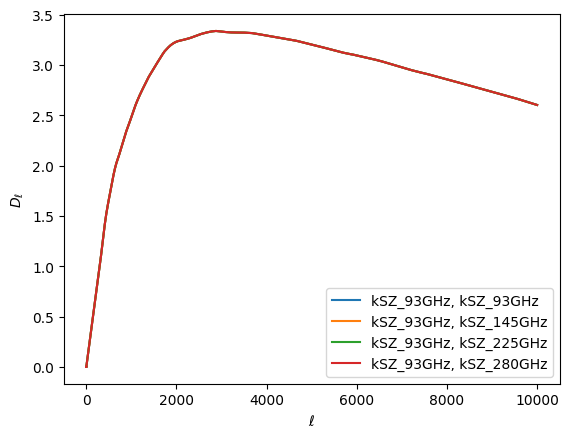

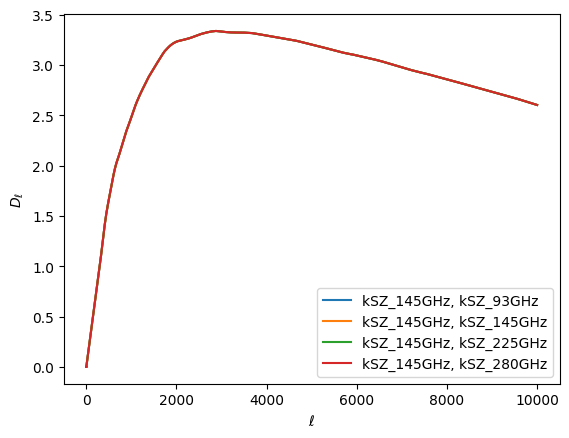

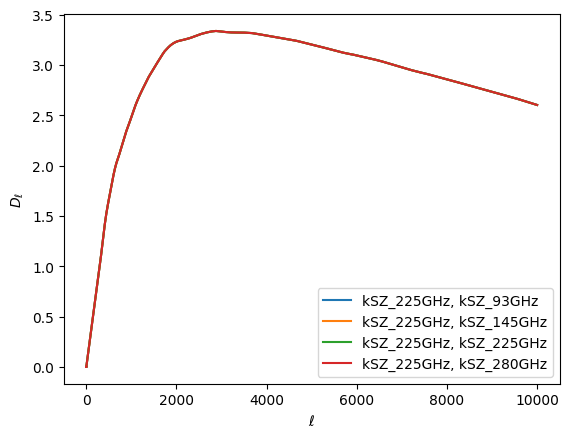

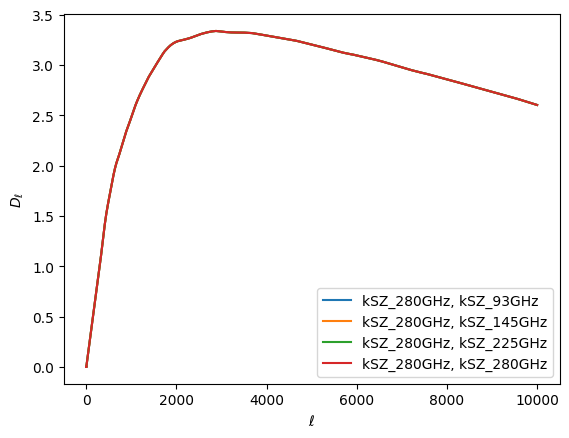

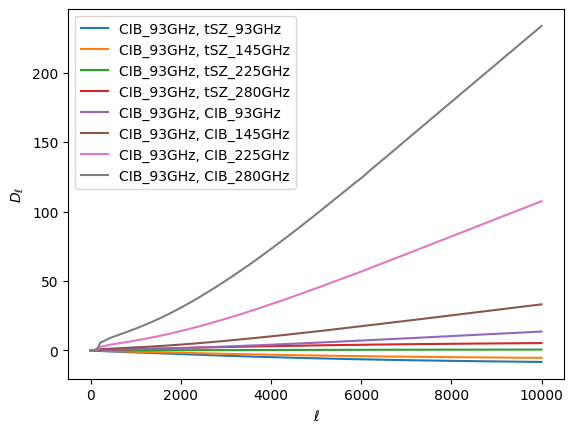

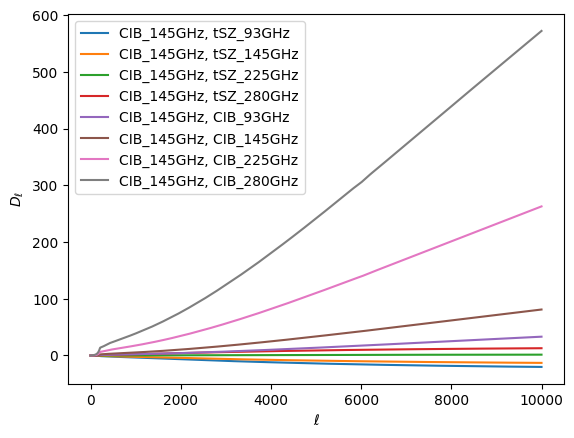

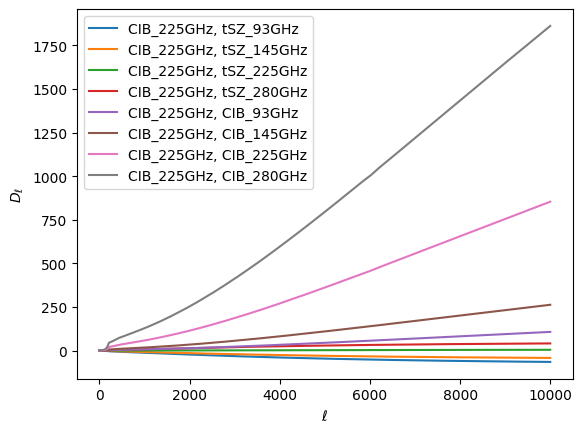

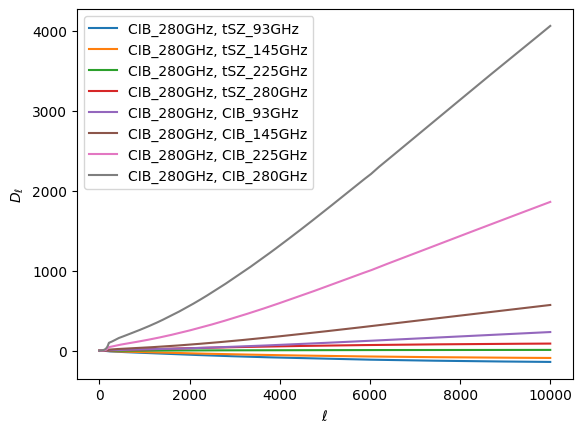

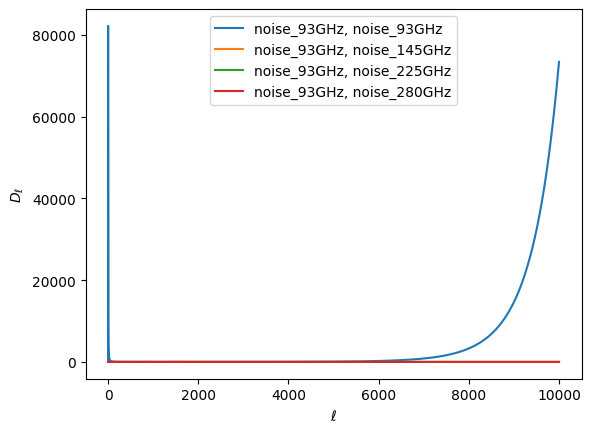

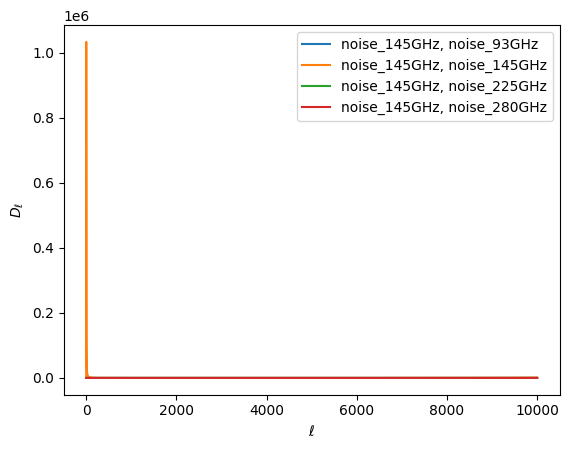

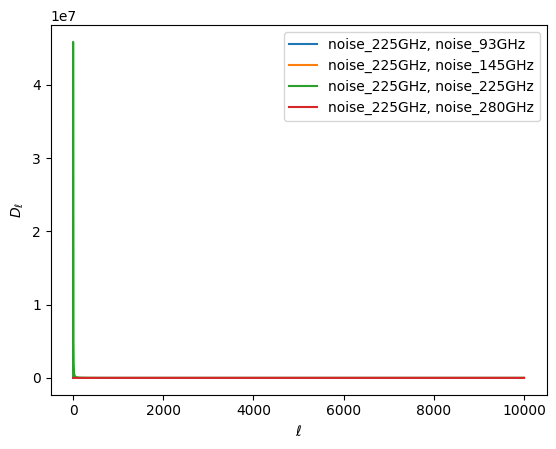

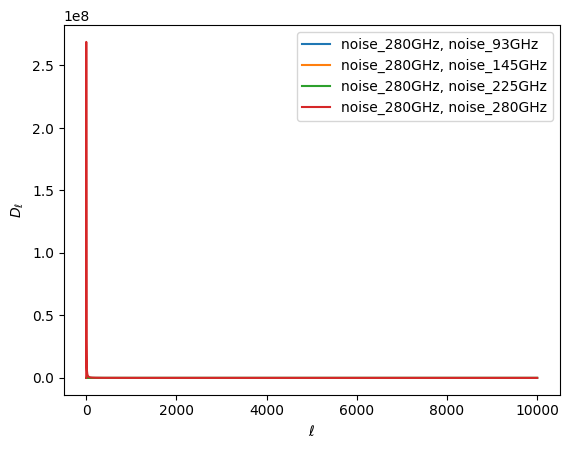

/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_84914/2520564436.py:166: RuntimeWarning: divide by zero encountered in true_divide
  spectrum = spectrum/(self.ells*(self.ells+1))*(2*np.pi)


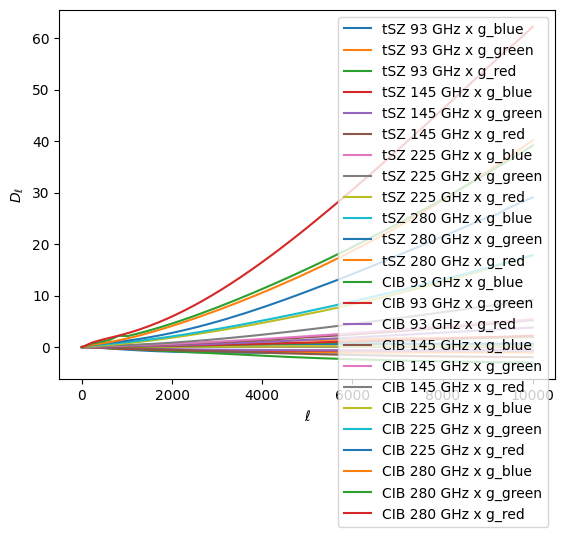

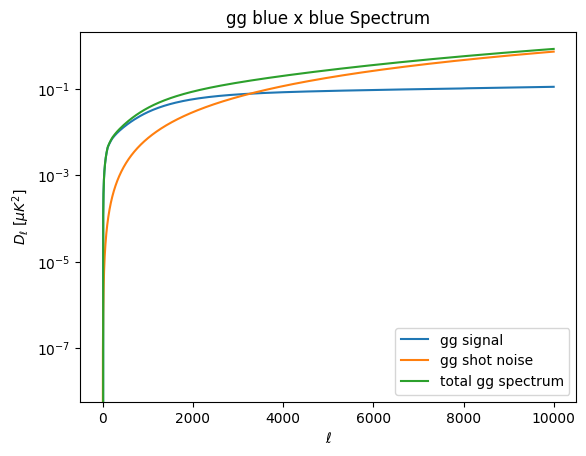

/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_84914/2520564436.py:203: RuntimeWarning: divide by zero encountered in true_divide
  self.gg_spectrum[a][b] = gg/(self.ells*(self.ells+1))*(2*np.pi)


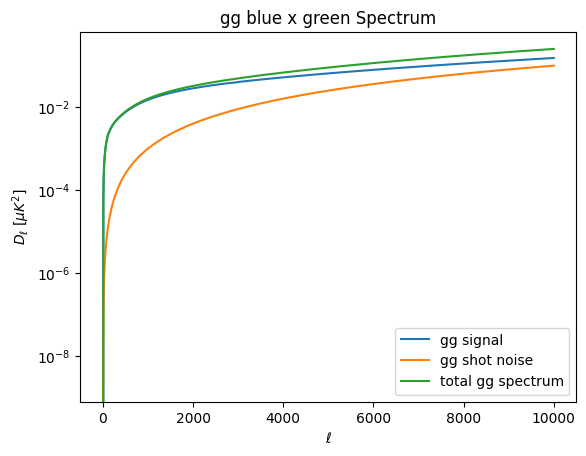

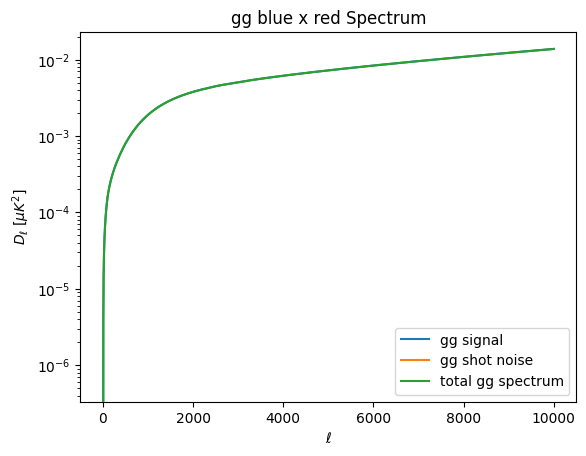

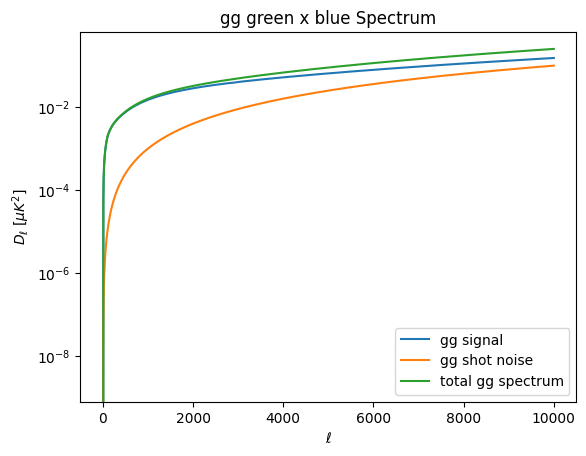

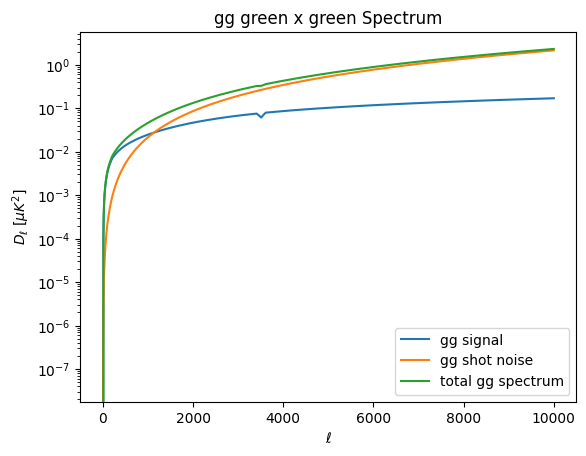

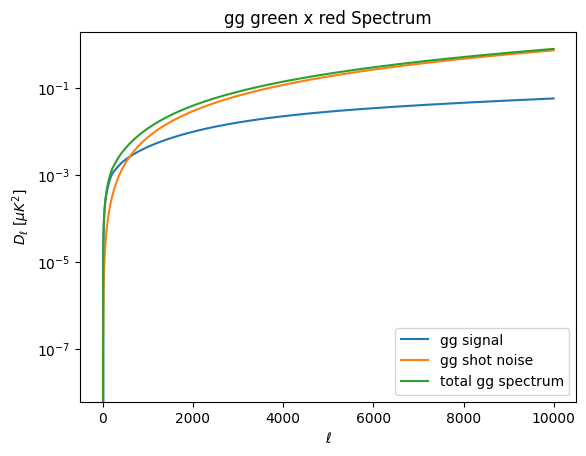

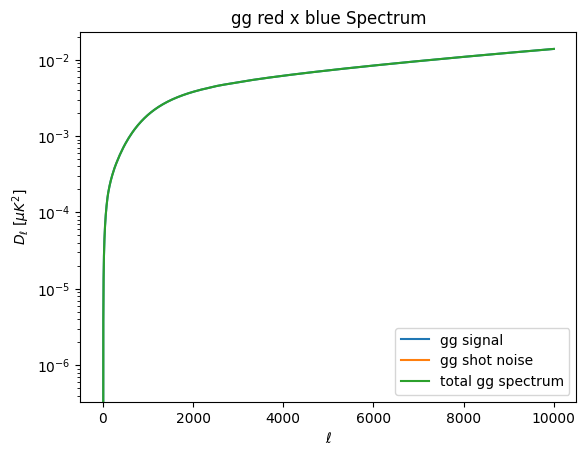

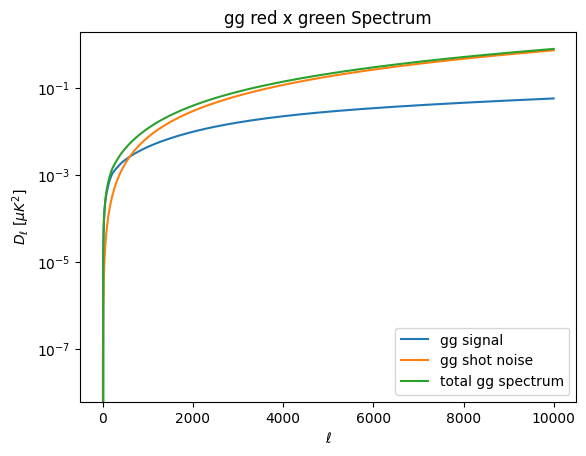

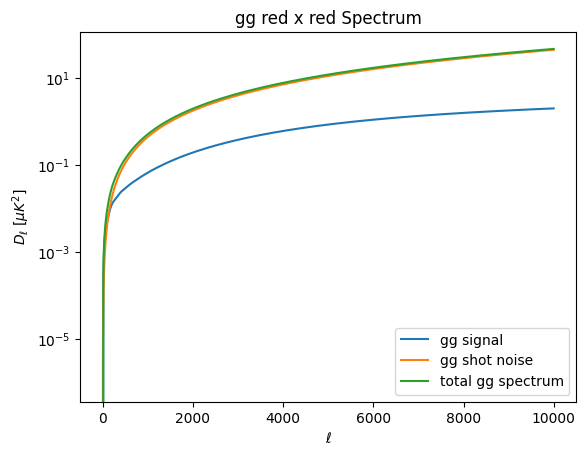

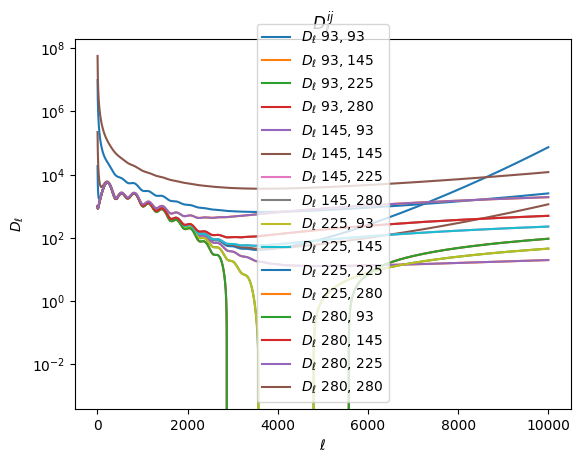

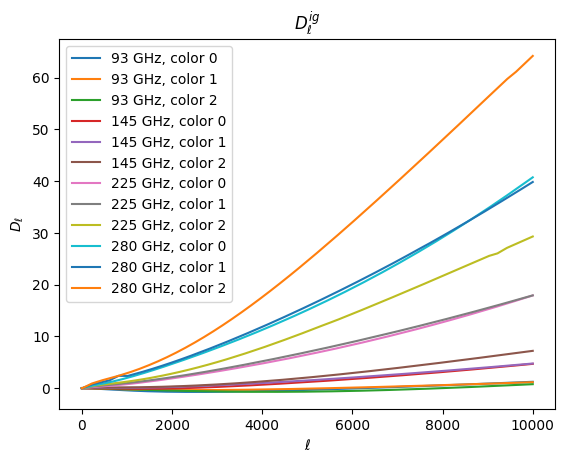

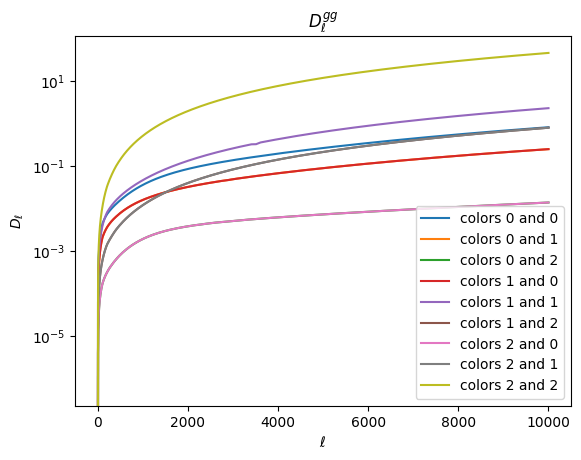

(array([[[1.06718015e+06,            nan,            nan, ...,
          4.59801729e-03, 4.60480881e-03, 4.61161037e-03],
         [0.00000000e+00,            nan,            nan, ...,
          1.22243880e-06, 1.22232597e-06, 1.22221318e-06],
         [0.00000000e+00,            nan,            nan, ...,
          2.81539597e-06, 2.81550560e-06, 2.81561523e-06],
         [0.00000000e+00,            nan,            nan, ...,
          5.79808352e-06, 5.79844858e-06, 5.79881357e-06]],
 
        [[0.00000000e+00,            nan,            nan, ...,
          1.22243880e-06, 1.22232597e-06, 1.22221318e-06],
         [1.34236804e+07,            nan,            nan, ...,
          7.14920323e-05, 7.15315408e-05, 7.15710727e-05],
         [0.00000000e+00,            nan,            nan, ...,
          1.40977308e-05, 1.40967991e-05, 1.40958678e-05],
         [0.00000000e+00,            nan,            nan, ...,
          3.08604283e-05, 3.08583939e-05, 3.08563602e-05]],
 
        [[0.000000

In [118]:
ellmax = 10000
ells = np.arange(ellmax+1)
base_dir = 'websky_11-18'
base_dir = 'websky_mean_HOD_updatedBlueShotNoise_12-03'
freqs = [27, 39, 93, 145, 225, 280]
freqs = [93, 145, 225, 280]
comps = ['CMB', 'tSZ', 'kSZ', 'CIB', 'noise']
gg_shot_noise = np.array([[0.92e-7, 6.22e-9, 0], [6.22e-9, 1.81e-7, 4.67e-8], [0, 4.67e-8, 29.6e-7]]) #index as gg_shot_noise[a][b] for blue, green, red, Alex shot noise
# gg_shot_noise = np.array([[0.92e-7, 6.22e-9/3, 0], [6.22e-9/3, 1.81e-8, 4.67e-8/3], [0, 4.67e-8/3, 29.6e-7]]) #index as gg_shot_noise[a][b] for blue, green, red
gg_shot_noise = np.array([[4.48e-8, 6.22e-9, 0], [6.22e-9, 1.35e-7, 4.67e-8], [0, 4.67e-8, 2.80e-6]]) #index as gg_shot_noise[a][b] for blue, green, red, shot noise from minimization

#uncomment below and add noise parameter for 1 uK arcmin noise 
noise_cl = np.zeros((len(freqs), ellmax+1))
for i in range(len(freqs)):
    if i<len(freqs)-2:
        noise = 1.
    else: #make noise higher for higher frequency :
        noise = 10.
    theta_fwhm = (1.4/60.)*(np.pi/180.)
    sigma = theta_fwhm/np.sqrt(8.*np.log(2.))
    W = (noise/60.)*(np.pi/180.)
    noise_cl[i] = W**2*np.exp(ells*(ells+1)*sigma**2)

spectra1 = spectra(base_dir, ellmax, freqs, comps, gg_shot_noise, noise=None) #use this line for SO noise levels
# spectra1 = spectra(base_dir, ellmax, freqs, comps, gg_shot_noise, noise=noise_cl) #use this line for 1 uk arcmin noise levels
spectra1.get_cls(plot=True)


/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_84914/2791777499.py:23: RuntimeWarning: invalid value encountered in sqrt
  self.rho_ab[a][b] = self.Clgg[a][b]/np.sqrt(self.Clgg[a][a]*self.Clgg[b][b])
/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_84914/2791777499.py:35: RuntimeWarning: invalid value encountered in sqrt
  self.rho_cib[b][i] = self.spectra.comp_cross_g_spectra[cib_idx][i][b]/np.sqrt(self.spectra.all_spectra[cib_idx,i,cib_idx,i] * self.Clgg[b,b])
/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_84914/2791777499.py:35: RuntimeWarning: invalid value encountered in true_divide
  self.rho_cib[b][i] = self.spectra.comp_cross_g_spectra[cib_idx][i][b]/np.sqrt(self.spectra.all_spectra[cib_idx,i,cib_idx,i] * self.Clgg[b,b])
/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_84914/2791777499.py:40: RuntimeWarning: invalid value encountered in sqrt
  self.c = np.einsum('abl,bil,iil,aal->ial', self.rho_ab_inv, self.rho_cib, np.sqrt(self.spect

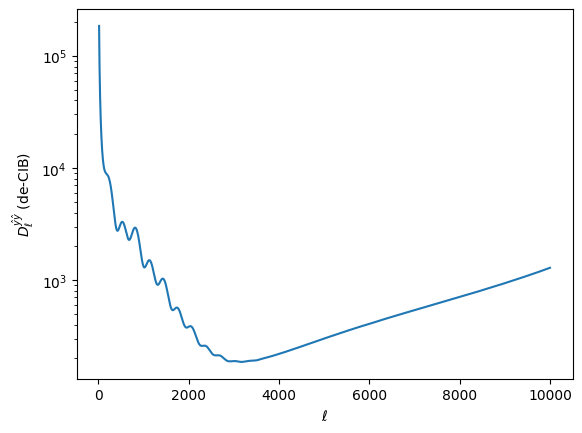

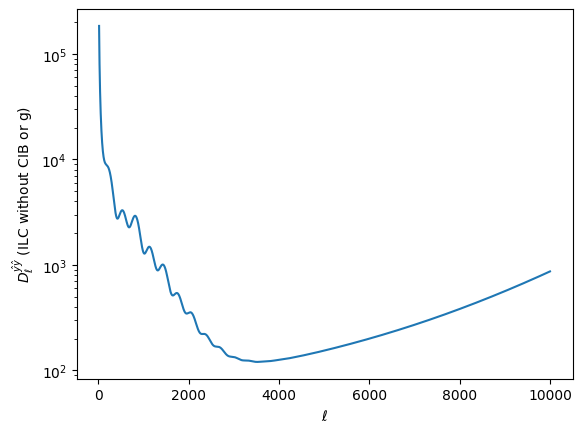

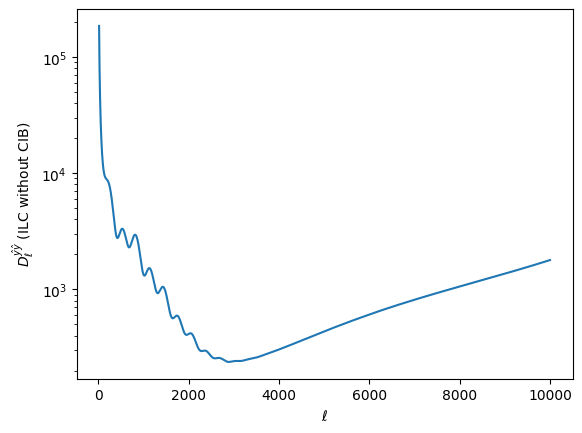

array([       nan,        nan,        nan, ..., 0.00011208, 0.00011209,
       0.0001121 ])

In [119]:
deltal = 10
m1 = de_CIB(spectra1, deltal)
m1.auto_spectrum(plot=True)
m3 = ILC_no_CIB_no_g(spectra1, deltal)
m3.ILC_auto_spectrum(plot=True)
m4 = ILC_no_g(spectra1, deltal)
m4.ILC_auto_spectrum(plot=True)

## Compare ILC Map Auto-Spectra from de-CIBing, g as a temperature map, and ILC without CIB or g, and ILC with CIB without g

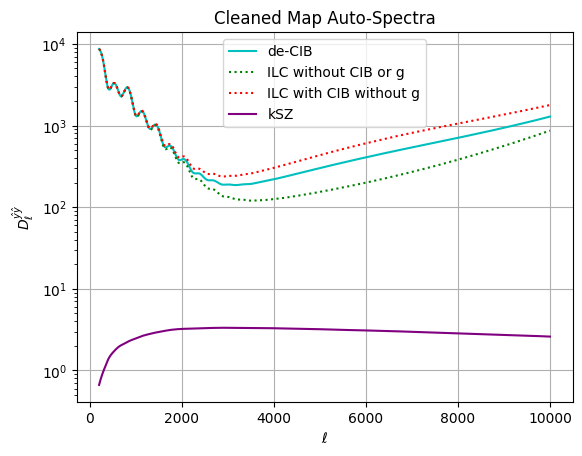

In [137]:
start = 200
stop = 10000
m1_color, m1_linestyle = 'c', 'solid'
m2_color, m2_linestyle = 'mediumpurple', 'dashed'
m3_color, m3_linestyle = 'g', 'dotted'
m4_color, m4_linestyle = 'r', 'dotted'


plt.clf()
plt.plot(ells[start:stop], (ells*(ells+1)*m1.Clyy/(2*np.pi))[start:stop], label='de-CIB', linestyle=m1_linestyle, color=m1_color)
plt.plot(ells[start:stop], (ells*(ells+1)*m3.Clyy/(2*np.pi))[start:stop], label='ILC without CIB or g', linestyle=m3_linestyle, color=m3_color)
plt.plot(ells[start:stop], (ells*(ells+1)*m4.Clyy/(2*np.pi))[start:stop], label='ILC with CIB without g', linestyle=m4_linestyle, color=m4_color)
kSZ = spectra1.all_spectra[comps.index('kSZ')][0][comps.index('kSZ')][0]
# noise = spectra1.all_spectra[comps.index('noise')][3][comps.index('noise')][3]
# plt.plot(ells[start:stop], (ells*(ells+1)*(kSZ+noise)/(2*np.pi))[start:stop], label='kSZ+noise')
plt.plot(ells[start:stop], (ells*(ells+1)*(kSZ)/(2*np.pi))[start:stop], label='kSZ', color='purple')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_{\ell}^{\hat{y}\hat{y}}$')
plt.yscale('log')
plt.legend()
plt.grid()
plt.title('Cleaned Map Auto-Spectra')
plt.show()

## Check Tclean correlation with $g^i$

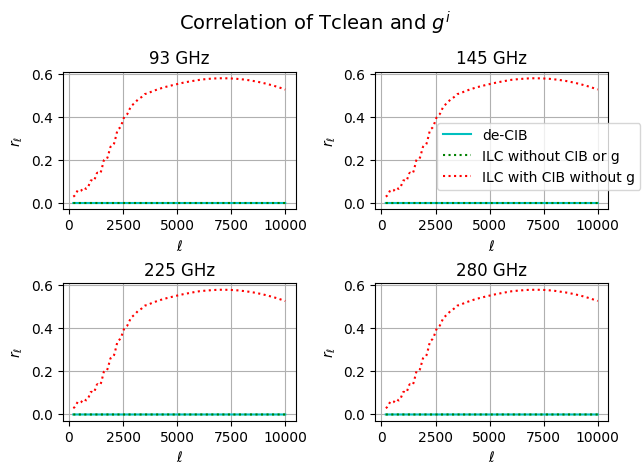

In [136]:
start = 200
cib_idx = spectra1.comps.index('CIB')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
axes = [ax1, ax2, ax3, ax4]

for i in range(len(spectra1.freqs)):
    Clgg = np.einsum('al,bl,abl->l', m1.c[i], m1.c[i], m1.Clgg)
    ILC_g_corr_method1 = (np.einsum('jl,al,jal->l', m1.w,m1.c[i],spectra1.Clig) - np.einsum('jl,jl,jal,bl,abl->l', m1.w, m1.f, m1.c, m1.c[i], m1.Clgg) )/np.sqrt(m1.Clyy*Clgg)
    comp_nocib_cross_g_spectra = np.delete(np.copy(spectra1.comp_cross_g_spectra), (cib_idx), axis=0)
    Clig_no_cib = np.einsum('aibl->ibl', comp_nocib_cross_g_spectra) #index as Clig[i][l]
    ILC_g_corr_method3 = np.einsum('il,al,ial->l', m3.w, m1.c[i], Clig_no_cib) / np.sqrt(m3.Clyy*Clgg)
    ILC_g_corr_method4 = np.einsum('il,al,ial->l', m4.w, m1.c[i], spectra1.Clig) / np.sqrt(m4.Clyy*Clgg)
    plt.axes(axes[i])
    plt.plot(ells[start:], ILC_g_corr_method1[start:], label='de-CIB', linestyle=m1_linestyle, color=m1_color)
    plt.plot(ells[start:], ILC_g_corr_method3[start:], label='ILC without CIB or g', linestyle=m3_linestyle, color=m3_color)
    plt.plot(ells[start:], ILC_g_corr_method4[start:], label='ILC with CIB without g', linestyle=m4_linestyle, color=m4_color)
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$r_{\ell}$')
    plt.title(f'{spectra1.freqs[i]} GHz')
    plt.grid()
    handles, labels = ax4.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.68,0.6))
plt.tight_layout()
fig = plt.gcf()
fig.suptitle(r"Correlation of Tclean and $g^i$", fontsize=14)
fig.subplots_adjust(top=0.85)
plt.show()

## View relative combinations of blue, green, red for optimal correlation with CIB

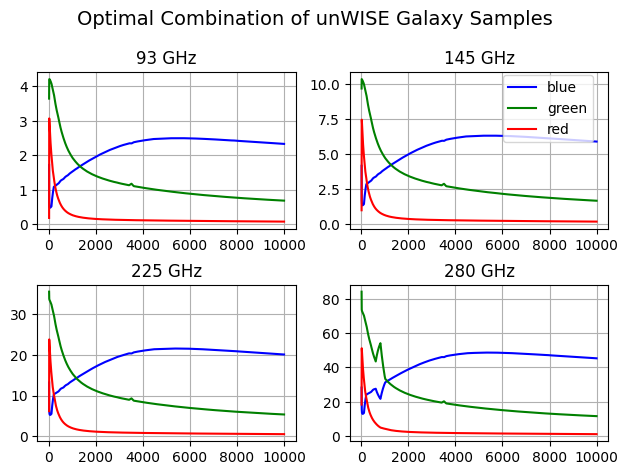

In [135]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
axes = [ax1, ax2, ax3, ax4]
for i in range(4):
    plt.axes(axes[i])
    plt.title(f'{spectra1.freqs[i]} GHz')
    plt.grid()
    for j in range(3):
        if j==0:
            color='blue'
        elif j==1:
            color='green'
        else:
            color='red'
        plt.plot(ells, m1.c[i][j], color=color, label=f'{color}')
    handles, labels = ax4.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.8,0.7))
plt.tight_layout()
fig = plt.gcf()
fig.suptitle(r"Optimal Combination of unWISE Galaxy Samples", fontsize=14)
fig.subplots_adjust(top=0.85)
plt.show()
plt.show()

## Check correlation of Tclean and CIB

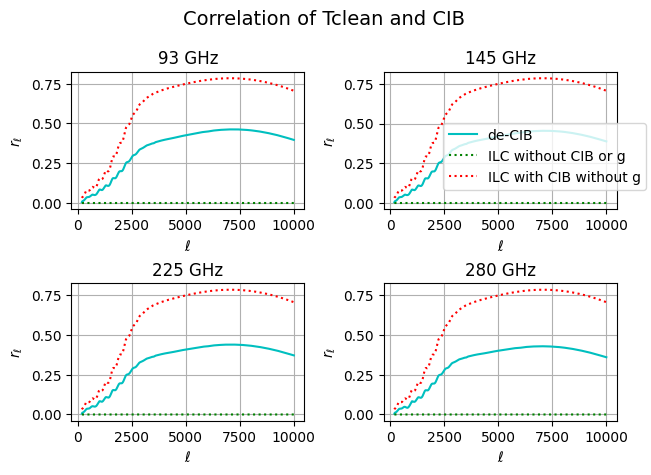

In [134]:
comp_cross_cib_spectra = np.zeros((len(spectra1.comps), len(spectra1.freqs), spectra1.ellmax+1))

cib_idx = spectra1.comps.index('CIB')

#index as comp_cross_cib_spectra[i][j] for cross-spectrum of CIB_i and T_j
comp_cross_cib_spectra = np.einsum('ibjl->ijl', spectra1.all_spectra[cib_idx])

#index as cib_cross_g_spectrum[i][b] for cross-spectrum CIB_i and g_b
cib_cross_g_spectrum = spectra1.comp_cross_g_spectra[cib_idx]

#for Method 3 (ILC with no CIB or g)
compnocib_cross_cib_spectra = np.delete(np.copy(spectra1.all_spectra), (cib_idx), axis=2)
compnocib_cross_cib_spectra = np.einsum('ibjl->ijl', compnocib_cross_cib_spectra[cib_idx])


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
axes = [ax1, ax2, ax3, ax4]

for i,freq1 in enumerate(spectra1.freqs):
    Cl_i_cib = comp_cross_cib_spectra[i]
    Cl_g_cib = cib_cross_g_spectrum[i]
    Cl_inocib_cib = compnocib_cross_cib_spectra[i]
    
    ILC_CIB_corr_method1 = (np.einsum('jl,jl->l', m1.w, comp_cross_cib_spectra[i]) - np.einsum('jl,jl,jal,al->l', m1.w,m1.f,m1.c,cib_cross_g_spectrum[i])) / np.sqrt(m1.Clyy*spectra1.all_spectra[cib_idx][i][cib_idx][i])
    ILC_CIB_corr_method3 = np.einsum('il,il->l', m3.w,Cl_inocib_cib) / np.sqrt(m3.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
    ILC_CIB_corr_method4 = np.einsum('il,il->l', m4.w,Cl_i_cib) / np.sqrt(m4.Clyy * spectra1.all_spectra[cib_idx][i][cib_idx][i])
    
    start = 200
    plt.axes(axes[i])
    plt.plot(ells[start:], ILC_CIB_corr_method1[start:], label=f'de-CIB', linestyle=m1_linestyle, color=m1_color)
    plt.plot(ells[start:], ILC_CIB_corr_method3[start:], label=f'ILC without CIB or g', linestyle=m3_linestyle, color=m3_color)
    plt.plot(ells[start:], ILC_CIB_corr_method4[start:], label=f'ILC with CIB without g', linestyle=m4_linestyle, color=m4_color)
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$r_{\ell}$')
    plt.title(f'{freq1} GHz')
    plt.grid()
    handles, labels = ax4.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.68,0.6))
plt.tight_layout()
fig = plt.gcf()
fig.suptitle(r"Correlation of Tclean and CIB", fontsize=14)
fig.subplots_adjust(top=0.85)
plt.show()

## Check fraction of CIB removed

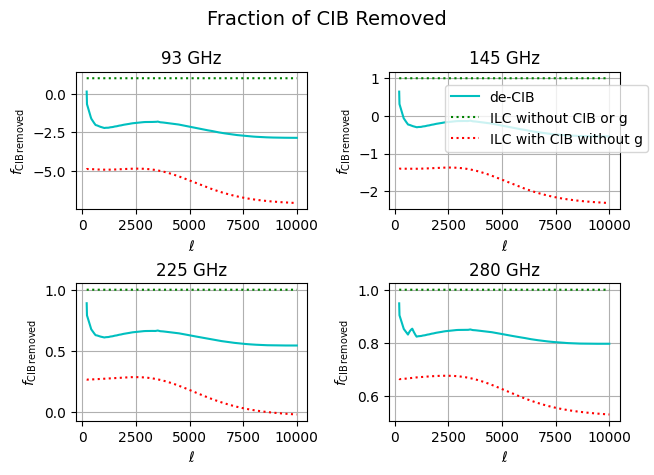

In [133]:
comp_cross_cib_spectra = np.zeros((len(spectra1.comps), len(spectra1.freqs), spectra1.ellmax+1))

cib_idx = spectra1.comps.index('CIB')

#index all_spectra as all_spectra[a][i][b][j]
comp_cross_cib_spectra = np.einsum('ibjl->ijl', spectra1.all_spectra[cib_idx])

#index as comp_cross_g_spectra[a][i] for cross-spectrum of g with component a at frequency i
cib_cross_g_spectrum = spectra1.comp_cross_g_spectra[cib_idx]

#for Method 3 (ILC with no CIB or g)
compnocib_cross_cib_spectra = np.delete(np.copy(spectra1.all_spectra), (cib_idx), axis=2)
compnocib_cross_cib_spectra = np.einsum('ibjl->ijl', compnocib_cross_cib_spectra[cib_idx])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
axes = [ax1, ax2, ax3, ax4]

for i,freq1 in enumerate(spectra1.freqs):
    Cl_i_cib = comp_cross_cib_spectra[i]
    Cl_g_cib = cib_cross_g_spectrum[i]
    Cl_inocib_cib = compnocib_cross_cib_spectra[i]


    f_CIB_removed_method1 = 1-((np.einsum('il,il->l', m1.w,Cl_i_cib)-np.einsum('il,il,ial,al->l', m1.w, m1.f, m1.c, spectra1.comp_cross_g_spectra[cib_idx][i]))) / spectra1.all_spectra[cib_idx][i][cib_idx][i]
    f_CIB_removed_method3 = 1-np.einsum('il,il->l', m3.w,Cl_inocib_cib) / spectra1.all_spectra[cib_idx][i][cib_idx][i]
    f_CIB_removed_method4 = 1-np.einsum('il,il->l', m4.w,Cl_i_cib) / spectra1.all_spectra[cib_idx][i][cib_idx][i]
    
    start = 200
    epsilon_high = 0.5
    epsilon_low = 1.5
    plt.axes(axes[i])
    plt.plot(ells[start:], f_CIB_removed_method1[start:], label=f'de-CIB', linestyle=m1_linestyle, color=m1_color)
    plt.plot(ells[start:], f_CIB_removed_method3[start:], label=f'ILC without CIB or g', linestyle=m3_linestyle, color=m3_color)
    plt.plot(ells[start:], f_CIB_removed_method4[start:], label=f'ILC with CIB without g', linestyle=m4_linestyle, color=m4_color)
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$f_{\mathrm{CIB \, removed}}$')
    plt.grid()
    plt.title(f'{freq1} GHz')
    handles, labels = ax4.get_legend_handles_labels()
#     plt.ylim(1.0-epsilon_low, 1.0+epsilon_high)

fig.legend(handles, labels, loc=(0.68,0.68))
plt.tight_layout()
fig = plt.gcf()
fig.suptitle(r"Fraction of CIB Removed", fontsize=14)
fig.subplots_adjust(top=0.85)
plt.show()

## Check fraction of CIB removed summed over all CIB frequencies

/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_84914/1961441010.py:16: RuntimeWarning: divide by zero encountered in true_divide
  f_CIB_removed_method3 = 1-np.einsum('il,jil,jjl->l', m3.w,compnocib_cross_cib_spectra, 1/spectra1.all_spectra[cib_idx, :, cib_idx, :])
/var/folders/4_/lnhhfcnn48583trlk1nzc53h0000gp/T/ipykernel_84914/1961441010.py:17: RuntimeWarning: divide by zero encountered in true_divide
  f_CIB_removed_method4 = 1-np.einsum('il,jil,jjl->l', m4.w,comp_cross_cib_spectra, 1/spectra1.all_spectra[cib_idx, :, cib_idx, :])


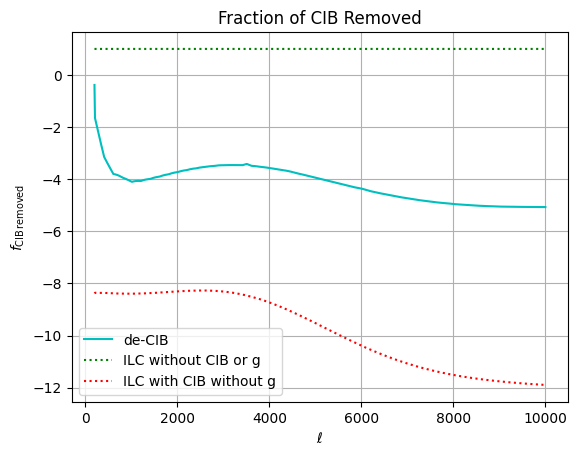

In [132]:
comp_cross_cib_spectra = np.zeros((len(spectra1.comps), len(spectra1.freqs), spectra1.ellmax+1))

cib_idx = spectra1.comps.index('CIB')

#index all_spectra as all_spectra[a][i][b][j]
comp_cross_cib_spectra = np.einsum('ibjl->ijl', spectra1.all_spectra[cib_idx])

#index as comp_cross_g_spectra[a][i] for cross-spectrum of g with component a at frequency i
cib_cross_g_spectrum = spectra1.comp_cross_g_spectra[cib_idx]

#for Method 3 (ILC with no CIB or g)
compnocib_cross_cib_spectra = np.delete(np.copy(spectra1.all_spectra), (cib_idx), axis=2)
compnocib_cross_cib_spectra = np.einsum('ibjl->ijl', compnocib_cross_cib_spectra[cib_idx])


f_CIB_removed_method3 = 1-np.einsum('il,jil,jjl->l', m3.w,compnocib_cross_cib_spectra, 1/spectra1.all_spectra[cib_idx, :, cib_idx, :]) 
f_CIB_removed_method4 = 1-np.einsum('il,jil,jjl->l', m4.w,comp_cross_cib_spectra, 1/spectra1.all_spectra[cib_idx, :, cib_idx, :]) 


f_CIB_removed_method1 = np.ones(spectra1.ellmax+1)
for i in range(len(spectra1.freqs)):
    Cl_i_cib = comp_cross_cib_spectra[i]
    f_CIB_removed_method1 -= ((np.einsum('il,il->l', m1.w,Cl_i_cib)-np.einsum('il,il,ial,al->l', m1.w, m1.f, m1.c, spectra1.comp_cross_g_spectra[cib_idx][i]))) / spectra1.all_spectra[cib_idx][i][cib_idx][i]



start = 200
epsilon_high = 0.7
epsilon_low = 0.5
plt.plot(ells[start:], f_CIB_removed_method1[start:], label=f'de-CIB', linestyle=m1_linestyle, color=m1_color)
plt.plot(ells[start:], f_CIB_removed_method3[start:], label=f'ILC without CIB or g', linestyle=m3_linestyle, color=m3_color)
plt.plot(ells[start:], f_CIB_removed_method4[start:], label=f'ILC with CIB without g', linestyle=m4_linestyle, color=m4_color)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$f_{\mathrm{CIB \, removed}}$')
plt.title(f'Fraction of CIB Removed')
# plt.ylim(1.0-epsilon_low, 1.0+epsilon_high)
plt.legend()
plt.grid()
plt.show()

## Check correlation of $\rm CIB_i$ with $g_i$

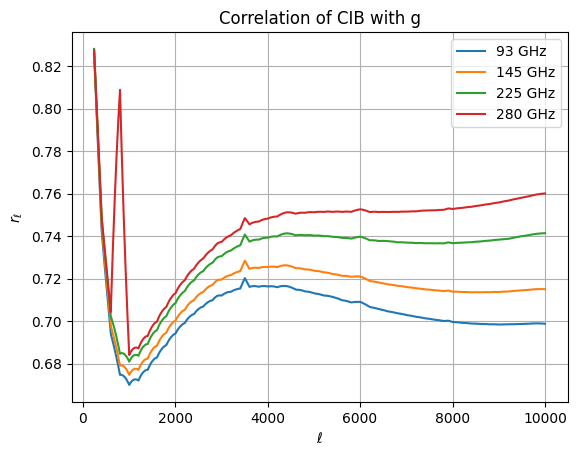

In [131]:
start = 250
plt.clf()
cib_idx = spectra1.comps.index('CIB')
for i in range(len(spectra1.freqs)):
    corr = np.einsum('al,al->l', m1.c[i], spectra1.comp_cross_g_spectra[cib_idx][i]) / np.sqrt(spectra1.all_spectra[cib_idx][i][cib_idx][i]*np.einsum('al,bl,abl->l', m1.c[i],m1.c[i],m1.Clgg))
    plt.plot(ells[start:], corr[start:], label=f'{freqs[i]} GHz')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$r_{\ell}$')
# plt.yscale('log')
plt.legend()
plt.grid()
plt.title('Correlation of CIB with g')
plt.show()

## Check correlation of Tclean and tSZ

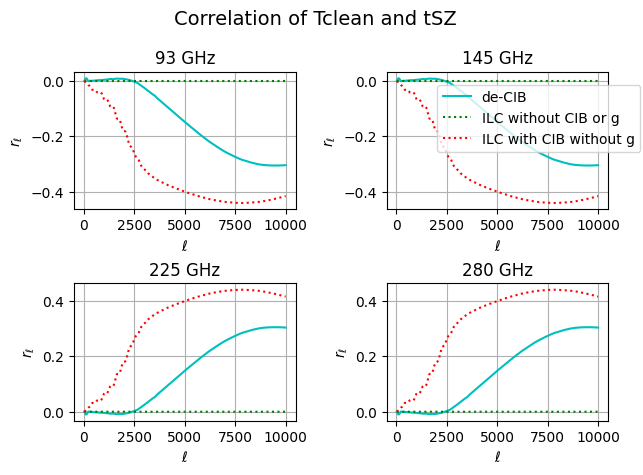

In [130]:
comp_cross_tsz_spectra = np.zeros((len(spectra1.comps), len(spectra1.freqs), spectra1.ellmax+1))

tsz_idx = spectra1.comps.index('tSZ')

#index as comp_cross_tsz_spectra[i][j] for cross-spectrum of tSZ_i and T_j
comp_cross_tsz_spectra = np.einsum('ibjl->ijl', spectra1.all_spectra[tsz_idx])

#index as tsz_cross_g_spectrum[i][b] for cross-spectrum tSZ_i and g_b
tsz_cross_g_spectrum = spectra1.comp_cross_g_spectra[tsz_idx]

#for Method 3 (ILC with no CIB or g)
compnocib_cross_tsz_spectra = np.delete(np.copy(spectra1.all_spectra), (cib_idx), axis=2)
compnocib_cross_tsz_spectra = np.einsum('ibjl->ijl', compnocib_cross_tsz_spectra[tsz_idx])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
axes = [ax1, ax2, ax3, ax4]

for i,freq1 in enumerate(spectra1.freqs):
    Cl_i_tsz = comp_cross_tsz_spectra[i]
    Cl_g_tsz = tsz_cross_g_spectrum[i]
    Cl_inocib_tsz = compnocib_cross_tsz_spectra[i]
    
    ILC_tsz_corr_method1 = (np.einsum('jl,jl->l', m1.w, comp_cross_tsz_spectra[i]) - np.einsum('jl,jl,jal,al->l', m1.w,m1.f,m1.c,tsz_cross_g_spectrum[i])) / np.sqrt(m1.Clyy*spectra1.all_spectra[tsz_idx][i][tsz_idx][i])
    ILC_tsz_corr_method3 = np.einsum('il,il->l', m3.w,Cl_inocib_tsz) / np.sqrt(m3.Clyy * spectra1.all_spectra[tsz_idx][i][tsz_idx][i])
    ILC_tsz_corr_method4 = np.einsum('il,il->l', m4.w,Cl_i_tsz) / np.sqrt(m4.Clyy * spectra1.all_spectra[tsz_idx][i][tsz_idx][i])
    
    start = 10
    plt.axes(axes[i])
    plt.plot(ells[start:], ILC_tsz_corr_method1[start:], label=f'de-CIB', linestyle=m1_linestyle, color=m1_color)
    plt.plot(ells[start:], ILC_tsz_corr_method3[start:], label=f'ILC without CIB or g', linestyle=m3_linestyle, color=m3_color)
    plt.plot(ells[start:], ILC_tsz_corr_method4[start:], label=f'ILC with CIB without g', linestyle=m4_linestyle, color=m4_color)
    plt.xlabel(r'$\ell$')
    plt.ylabel(r'$r_{\ell}$')
    plt.title(f'{freq1} GHz')
    plt.grid()
    handles, labels = ax4.get_legend_handles_labels()

fig.legend(handles, labels, loc=(0.68,0.68))
plt.tight_layout()
fig = plt.gcf()
fig.suptitle(r"Correlation of Tclean and tSZ", fontsize=14)
fig.subplots_adjust(top=0.85)
plt.show()


## Signal to Noise Ratio for kSZ

### $\sigma^2(C_{\ell}) = \frac{2}{(2\ell+1)f_{\rm sky}} (C_{\ell}^{\rm tot})^2$ and $\rm SNR = \sqrt{\sum_{\ell}\frac{(C_{\ell}^{\rm kSZ})^2}{\sigma^2(C_{\ell})}}$

In [128]:
def get_snr(Clyy):
    fsky = 0.4 #for SO
    sigma = 2/((2*ells+1)*fsky)*Clyy**2
    ksz_idx = spectra1.comps.index('kSZ')
    ksz = spectra1.all_spectra[ksz_idx][0][ksz_idx][0]
    ratio = ksz**2/sigma
    ratio = np.nan_to_num(ratio)
    SNR = np.sqrt(sum(ratio))
    return SNR

In [129]:
snr_m1 = get_snr(m1.Clyy)
snr_m3 = get_snr(m3.Clyy)
snr_m4 = get_snr(m4.Clyy)
print('SNR for deCIB: ', snr_m1)
print('SNR for ILC without CIB or g (optimal): ', snr_m3)
print('SNR for ILC with CIB without g: ', snr_m4)

SNR for deCIB:  36.4871441873379
SNR for ILC without CIB or g (optimal):  63.131134593626825
SNR for ILC with CIB without g:  26.88303557632907
